<a href="https://colab.research.google.com/github/LShahmiri/Computer_vision-Image_processing_Projects/blob/master/EMGMM_PCA%20(Reviewers)/EMGMM_PCA_(Reviewers).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EMGMM

<ipython-input-28-5212355e188a>:115: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(path)


K=4, iterations: 74
Successful


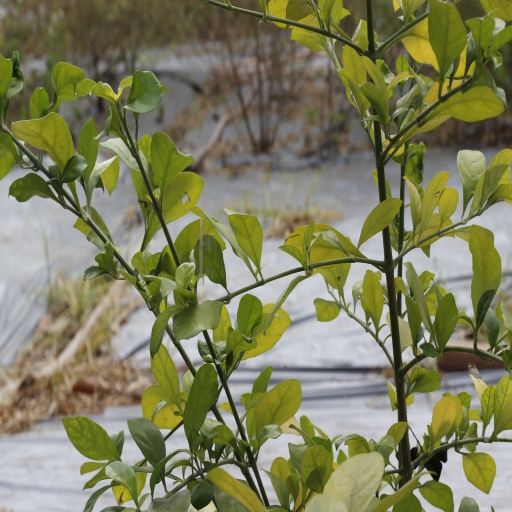

This is the original image


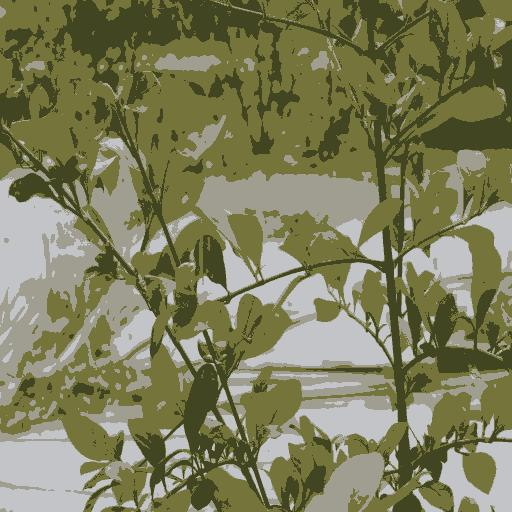

This is the EMGMM preprocessing result


In [28]:

from __future__ import print_function
from __future__ import division
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import imageio
import sys
import pandas as pd
from sklearn.decomposition import PCA
import cv2
from skimage.io import imshow, imread
from skimage.color import rgb2hsv, rgb2gray, rgb2yuv
from skimage import color, exposure, transform
from skimage.exposure import histogram, cumulative_distribution, equalize_hist
from skimage import img_as_ubyte, img_as_uint
from google.colab.patches import cv2_imshow
import glob
import nibabel as nib

filename = ''

class EM():

    def __init__(self, K):
        self.K = K

    def fit(self, X):
        K = self.K
        M, S, P, mixtureMatrix = self.initializeMatrices(K)
        tol = 0.001
        iters = 200
        self.logLikelihoods = []
        oldL = self.logLikelihood(mixtureMatrix)

        for i in range(iters):
            sys.stdout.write('\r'+ "K=" + str(K) +", iterations: " + str(i))
            Gamma = self.calc_Gamma(mixtureMatrix)
            Nk = self.calc_Nk(Gamma)
            M = self.calc_M(X, Gamma, Nk)
            S = self.calc_S(X, Gamma, Nk , M)
            P = self.calc_P(Nk, X.shape[0])

            mixtureMatrix = self.GaussianMixture(X, M, S, P)
            L = self.logLikelihood(mixtureMatrix)
            self.logLikelihoods.append(L)

            if (L - oldL < 0):
                print("\nThere is a problem!")
                return
            elif (L - oldL < tol):
                break

            oldL = L

        print("\nSuccessful")
        self.Xpred = M[Gamma.argmax(axis=1)]

    def GaussianMixture(self, X, M, S, P):
        S = np.array([np.eye(X.shape[1]) * Sk for Sk in S])
        mixture = np.zeros((X.shape[0], M.shape[0]))
        for k in range(M.shape[0]):
            mixture[:, k] = stats.multivariate_normal(M[k], S[k]).pdf(X)
        return P.T * mixture

    def calc_Gamma(self, mixtureMatrix):
        Gamma = mixtureMatrix
        Gamma = Gamma / np.sum(Gamma, axis=1).reshape(-1, 1)
        return Gamma

    def calc_Nk(self, Gamma):
        return np.sum(Gamma, axis=0).reshape(-1, 1)

    def calc_M(self, X, Gamma, Nk):
        return Gamma.T.dot(X) / Nk

    def calc_S(self, X, Gamma, Nk, M):
        S = np.ones((M.shape[0], 1))
        for k in range(M.shape[0]):
            S[k] = np.sum(np.sum(Gamma[:, k].reshape((-1, 1)) * np.square(X - M[k]), axis=1))

        return np.array(S) / (X.shape[1] * Nk)

    def calc_P(self, Nk, N):
        return Nk / N

    def initializeMatrices(self, K):
        M = np.random.uniform(0, 1, (K, X.shape[1]))
        S = np.random.uniform(0, 1, (K, 1))
        P = np.ones((K, 1)) * 1 / K
        mixtureMatrix = self.GaussianMixture(X, M, S, P)
        return M, S, P, mixtureMatrix

    def logLikelihood(self, mixtureMatrix):
        return np.sum(np.log(np.sum(mixtureMatrix, axis=1)))

    def reconstError(self, X):
        return np.linalg.norm((X - self.Xpred) * 255) / X.shape[0]

    def savePredictedImage(self, shape):
        Xpred = (self.Xpred * 255).astype(np.uint8)
        Xpred = Xpred.reshape(shape)

        imageio.imwrite('/content/drive/MyDrive/Datasets/result/13.jpg', Xpred)


# def runForAllK(Xtrue, shape):
#     for K in [1, 2, 4, 8, 16, 32, 64]:
#         em = EM(K)
#         em.fit(Xtrue)
#         em.savePredictedImage(shape)
#         print("Reconstruction error= ", em.reconstError(Xtrue), "\n")


path = '/content/drive/MyDrive/Datasets/167nomi/Acanthus integrifolius/13.JPG'
im = imageio.imread(path)
shape = im.shape
im = im.reshape((im.shape[0] * im.shape[1], 3))
X = im / 255
em = EM(4)
em.fit(X)
em.savePredictedImage(shape)


# Display the original and modified images


import cv2
from google.colab.patches import cv2_imshow
# Load the original image
original_image = cv2.imread(path)

# Display the original image
cv2_imshow(original_image)
print('This is the original image')

# Load and display the predicted image
predicted_image = cv2.imread('/content/drive/MyDrive/Datasets/result/13.jpg')
cv2_imshow(predicted_image)
print('This is the EMGMM preprocessing result')




#PCA

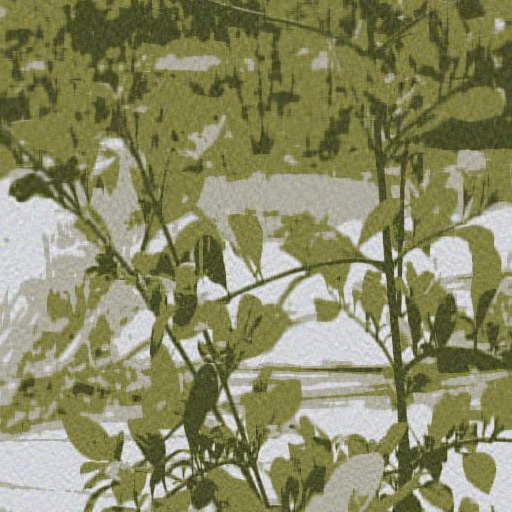

This image is result of PCA after EMGMM


In [29]:
import cv2
import os
import numpy as np
from sklearn.decomposition import PCA
img = cv2.imread('/content/drive/MyDrive/Datasets/result/13.jpg')

# Assuming you have already loaded and processed the image into Xpred
# Xpred = ...

# Convert Xpred to a grayscale image
image_sum = img.sum(axis=2)
image_bw = image_sum / image_sum.max()

# Perform PCA on the grayscale image
pca = PCA()
pca.fit(image_bw)
var_cumu = np.cumsum(pca.explained_variance_ratio_) * 100
k = np.argmax(var_cumu > 95)

# Split the color channels
blue, green, red = cv2.split(img)
df_blue = blue / 255
df_green = green / 255
df_red = red / 255

# Apply PCA on each color channel
pca_b = PCA(n_components=k)
pca_b.fit(df_blue)
trans_pca_b = pca_b.transform(df_blue)

pca_g = PCA(n_components=k)
pca_g.fit(df_green)
trans_pca_g = pca_g.transform(df_green)

pca_r = PCA(n_components=k)
pca_r.fit(df_red)
trans_pca_r = pca_r.transform(df_red)

# Inverse transform to get the reduced color channels
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)

# Merge the reduced color channels
img_reduced = (cv2.merge((b_arr, g_arr, r_arr)))

# Normalize the result
result = cv2.normalize(img_reduced, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Save the processed image
cv2.imwrite('/content/drive/MyDrive/Datasets/result/PCA.jpg', result)
PCA = cv2.imread('/content/drive/MyDrive/Datasets/result/PCA.jpg')

cv2_imshow(PCA)
print('This image is result of PCA after EMGMM')
